This dataset is acquired from the following Kaggle data source:
https://www.kaggle.com/datasets/camnugent/california-housing-prices

This script has benefited immensely from the following:

Julien Solal's excellent kernel on feature engineering
https://www.kaggle.com/code/juliencs/a-study-on-regression-applied-to-the-ames-dataset/notebook

Serigne Cisse's kernel on the Ames House Price dataset
https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard/notebook

Cameron Nugent's kernel on Geospatial Feature Engineering
https://www.kaggle.com/code/camnugent/geospatial-feature-engineering-and-visualization/notebook

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import multiprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats import boxcox
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from geopy import distance as dist  
from scipy.special import inv_boxcox

#Force pd to display print in full
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

data = pd.read_csv('housing.csv')
#Random reshuffle of index to avoid possible implicit sorting
data = data.reindex(np.random.permutation(data.index))
y = data['median_house_value']
X = data.drop('median_house_value',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Data transformation, feature crossing and engineering

We begin by exploring our data a little bit.

In [37]:
def cal_isna(df):
    '''
    Calculate and return a series of missing data ratio, only features with missing data are returned
    '''
    df_isna_non_zero=(df.isna().sum()/df.shape[0])!=0
    df_isna=(df.isna().sum()/df.shape[0])[df_isna_non_zero].sort_values(ascending=False)
    return df_isna

print('Missing data in training set summary:','\n',cal_isna(X_train))
print('Missing data in testing set summary:','\n',cal_isna(X_test))

Missing data in training set summary: 
 Series([], dtype: float64)
Missing data in testing set summary: 
 Series([], dtype: float64)


There are only about 1% of data missing, and it is unclear whether they are missing at random, or if there is an underlying reason - very little background info is available for this dataset.
Therefore perhaps it is the easiest to simply remove them.

In [18]:
missing_index_train=X_train[X_train['total_bedrooms'].isna()].index
missing_index_test=X_test[X_test['total_bedrooms'].isna()].index

X_train=X_train.dropna(subset=['total_bedrooms'])
y_train=y_train.drop(index=missing_index_train)
X_test=X_test.dropna(subset=['total_bedrooms'])
y_test=y_test.drop(index=missing_index_test)

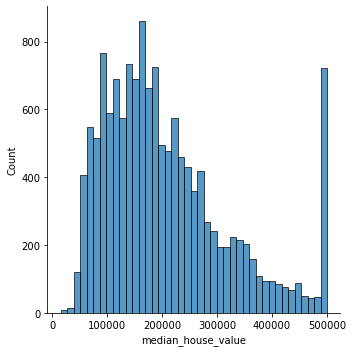

In [19]:
y_plot=sns.displot(y_train)

It is very strange that there are over 700 districts with the same median house value (MHV), 500000.

In [20]:
print('Ratio of MHV values','\n',(y_train.value_counts()/y_train.shape[0]).head(10))

Ratio of MHV values 
 500001.0    0.047206
137500.0    0.005665
162500.0    0.005315
112500.0    0.005035
225000.0    0.004546
187500.0    0.004196
350000.0    0.003916
87500.0     0.003846
275000.0    0.003147
175000.0    0.002937
Name: median_house_value, dtype: float64


0.048 of the MHV data are 500k, the next most numerous MHV is 137500, with 0.006 of the data, this is definitely not right.

I suspect these are MHV that are >500k but are censored - any MHV>500k are categorized as 500k.

As it is, I think the best approach to leave them be, as deleting them would bias the model.

Furthermore, as random forest regression will be used later, deleting the right censored data would make prediction on any MHV>500k an extrapolation, which RF cannot do.

It also seems that the target variable is skewed, let's Box-Cox transform it to tackle that.

Lambda for train= 0.12203858784080607


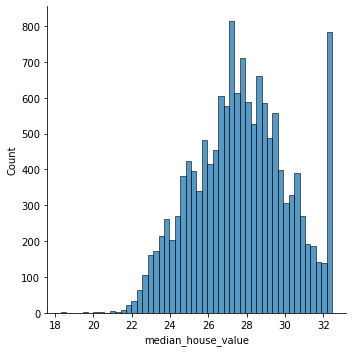

In [21]:
y_train[:], lamb_train = boxcox(y_train)
print('Lambda for train=',lamb_train)
y_boxcox_plot=sns.displot(y_train)

The target variable now looks a lot more normally distributed.

In [22]:
for feature in X_train.columns:
    print(X_train[feature].describe())

count    14299.000000
mean      -119.557403
std          2.000714
min       -124.300000
25%       -121.770000
50%       -118.480000
75%       -118.010000
max       -114.470000
Name: longitude, dtype: float64
count    14299.000000
mean        35.624211
std          2.139275
min         32.540000
25%         33.930000
50%         34.250000
75%         37.720000
max         41.950000
Name: latitude, dtype: float64
count    14299.000000
mean        28.641513
std         12.523053
min          1.000000
25%         18.000000
50%         29.000000
75%         37.000000
max         52.000000
Name: housing_median_age, dtype: float64
count    14299.000000
mean      2648.664592
std       2197.761720
min          6.000000
25%       1448.000000
50%       2127.000000
75%       3159.500000
max      32627.000000
Name: total_rooms, dtype: float64
count    14299.000000
mean       541.079446
std        426.011754
min          1.000000
25%        295.000000
50%        437.000000
75%        652.000000
max 

It maybe a good idea to cross both longitude and latitude to create a new feature.

Crossing a numeric feature would result in an explosion of feature space.
So let's bucket them before creating a boolean feature which indicates a region's longitude and latitude.

In [23]:
long_bins=[long for long in range(-125,-110,5)]
X_train["longitude_buc"] = pd.cut(X_train.longitude, long_bins,include_lowest=True)
lat_bins=[lat for lat in range(30,45,5)]
X_train["latitude_buc"] = pd.cut(X_train.latitude, lat_bins,include_lowest=True)

X_train['lat:(29.999, 35.0] & long:(-125.001, -120.0]'] = ((X_train["latitude_buc"]==pd.Interval(29.999, 35.0, closed='right'))&(X_train["longitude_buc"]==pd.Interval(-125.001, -120.0, closed='right'))).astype(int)
X_train['lat:(29.999, 35.0] & long:(-120.0, -115.0]'] = ((X_train["latitude_buc"]==pd.Interval(29.999, 35.0, closed='right'))&(X_train["longitude_buc"]==pd.Interval(-120.0, -115.0, closed='right'))).astype(int)
X_train['lat:(35.0, 40.0] & long:(-125.001, -120.0]'] = ((X_train["latitude_buc"]==pd.Interval(35.0, 40.0, closed='right'))&(X_train["longitude_buc"]==pd.Interval(-125.001, -120.0, closed='right'))).astype(int)
X_train['lat:(35.0, 40.0] & long:(-120.0, -115.0]'] = ((X_train["latitude_buc"]==pd.Interval(35.0, 40.0, closed='right'))&(X_train["longitude_buc"]==pd.Interval(-120.0, -115.0, closed='right'))).astype(int)

X_test["longitude_buc"] = pd.cut(X_test.longitude, long_bins,include_lowest=True)
X_test["latitude_buc"] = pd.cut(X_test.latitude, lat_bins,include_lowest=True)
X_test['lat:(29.999, 35.0] & long:(-125.001, -120.0]'] = ((X_test["latitude_buc"]==pd.Interval(29.999, 35.0, closed='right'))&(X_test["longitude_buc"]==pd.Interval(-125.001, -120.0, closed='right'))).astype(int)
X_test['lat:(29.999, 35.0] & long:(-120.0, -115.0]'] = ((X_test["latitude_buc"]==pd.Interval(29.999, 35.0, closed='right'))&(X_test["longitude_buc"]==pd.Interval(-120.0, -115.0, closed='right'))).astype(int)
X_test['lat:(35.0, 40.0] & long:(-125.001, -120.0]'] = ((X_test["latitude_buc"]==pd.Interval(35.0, 40.0, closed='right'))&(X_test["longitude_buc"]==pd.Interval(-125.001, -120.0, closed='right'))).astype(int)
X_test['lat:(35.0, 40.0] & long:(-120.0, -115.0]'] = ((X_test["latitude_buc"]==pd.Interval(35.0, 40.0, closed='right'))&(X_test["longitude_buc"]==pd.Interval(-120.0, -115.0, closed='right'))).astype(int)

We may also need to encode ocean_proximity because it is a categorical feature.

In [24]:
print(X_train['ocean_proximity'].value_counts())

<1H OCEAN     6347
INLAND        4547
NEAR OCEAN    1838
NEAR BAY      1563
ISLAND           4
Name: ocean_proximity, dtype: int64


There is an order of preference built into these categories, with ISLAND being the most desirable and <1H OCEAN being the least desirable, let's ordinal encode this feature.

In [25]:
X_train = X_train.replace({"ocean_proximity" : {"ISLAND" : 5, "NEAR BAY" : 4, 
                                                "NEAR OCEAN" : 3,
                                                "INLAND" : 2,
                                                "<1H OCEAN" : 1}})
X_test = X_test.replace({"ocean_proximity" : {"ISLAND" : 5, "NEAR BAY" : 4, 
                                                "NEAR OCEAN" : 3,
                                                "INLAND" : 2,
                                                "<1H OCEAN" : 1}})

Let's also cross the amount of rooms and bedrooms.

In [26]:
X_train['rooms x bedrooms']=X_train['total_rooms']*X_train['total_bedrooms']
X_test['rooms x bedrooms']=X_test['total_rooms']*X_test['total_bedrooms']

The numeric features are also on different scales, so we should scale them too.
But we should leave it till afterwards because we will create polynomial features. One of which would be sqrt.

Let's see how correlated the features are.

In [27]:
train_corr_df = X_train.copy()
train_corr_df['median_house_value']=y_train
corr_table=train_corr_df.corr()['median_house_value'].sort_values(ascending=False)
print(corr_table)

median_house_value                              1.000000
median_income                                   0.661811
lat:(29.999, 35.0] & long:(-120.0, -115.0]      0.201173
total_rooms                                     0.149674
households                                      0.095614
housing_median_age                              0.083938
total_bedrooms                                  0.076574
rooms x bedrooms                                0.059297
lat:(35.0, 40.0] & long:(-125.001, -120.0]      0.029677
population                                      0.012081
ocean_proximity                                -0.012723
lat:(29.999, 35.0] & long:(-125.001, -120.0]   -0.014737
longitude                                      -0.018865
latitude                                       -0.194132
lat:(35.0, 40.0] & long:(-120.0, -115.0]       -0.351873
Name: median_house_value, dtype: float64


Let's create new features by making polynomial features out of the top 5 most correlated features.

In [28]:
poly_features=['median_income','total_rooms','households','total_bedrooms','housing_median_age']

def polynomial_features(df,features):
    '''
    Takes a df and a list of features and returns a df with polynomial features
    created out of those features
    '''
    for feature in features:
        name_sq=feature+str('**2')
        df[name_sq]=df[feature]**2
        
        name_cube=feature+str('**3')
        df[name_cube]=df[feature]**3
        
        name_sqrt=feature+str(' sqrt')
        df[name_sqrt]=np.sqrt(df[feature])
    return df

X_train=polynomial_features(X_train,poly_features)
X_test=polynomial_features(X_test,poly_features)

We should be aware of skewness, because later we will be using Random Forest regressor, which is rather sensitive to skewness.
Again let's perform a Boxcox transformation on the skewed numeric features.

In [29]:
def check_skew_boxcox(df,features,threshold=0.5):
    '''
    Check for skewed feature and return df with skewed features transformed

    '''
    from scipy.stats import skew
    skewness = df[features].apply(lambda x: skew(x))
    skewness = skewness[abs(skewness) > 0.5]
    print(str(skewness.shape[0]) + " skewed numerical features to transform")
    print('They are',[feature for feature in skewness.index])
    for feature in skewness.index:
        df[feature]=boxcox(df[feature])[0]
    return df

features=['housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income']
X_train=check_skew_boxcox(X_train,features)
X_test=check_skew_boxcox(X_test,features)

5 skewed numerical features to transform
They are ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
5 skewed numerical features to transform
They are ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


Now we scale the features.

In [30]:
num_features=['longitude', 'latitude','housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']
cat_features=['ocean_proximity', 'longitude_buc', 'latitude_buc',
'lat:(29.999, 35.0] & long:(-125.001, -120.0]',
'lat:(29.999, 35.0] & long:(-120.0, -115.0]',
'lat:(35.0, 40.0] & long:(-125.001, -120.0]',
'lat:(35.0, 40.0] & long:(-120.0, -115.0]']

scaler = StandardScaler()
#Scaling all numeric features except longitude and latitude, as that may distort
#the location
X_train_for_scaling=X_train[num_features].drop(['longitude', 'latitude'],axis=1)
X_train_scaling_cols=X_train_for_scaling.columns
X_train_scaling_index=X_train_for_scaling.index
X_train_for_scaling=scaler.fit_transform(X_train_for_scaling)
X_train_for_scaling = pd.DataFrame(X_train_for_scaling,columns=X_train_scaling_cols,index=X_train_scaling_index)
for feature in X_train_for_scaling.columns:
    X_train[feature]=X_train_for_scaling[feature].values

X_test_for_scaling=X_test[num_features].drop(['longitude', 'latitude'],axis=1)
X_test_scaling_cols=X_test_for_scaling.columns
X_test_scaling_index=X_test_for_scaling.index
X_test_for_scaling=scaler.transform(X_test_for_scaling)
X_test_for_scaling=pd.DataFrame(X_test_for_scaling,columns=X_test_scaling_cols,index=X_test_scaling_index)
for feature in X_test_for_scaling.columns:
    X_test[feature]=X_test_for_scaling[feature].values

## Geospatial feature engineering

We now move onto engineering geospatial features.

In [31]:
city_lat_long = pd.read_csv('cal_cities_lat_long.csv')
city_pop_data = pd.read_csv('cal_populations_city.csv')
county_pop_data = pd.read_csv('cal_populations_county.csv')
    

city_coords = {}
for dat in city_lat_long.iterrows():
    row = dat[1]
    if row['Name'] not in city_pop_data['City'].values:   
        continue           
    else: 
        city_coords[row['Name']] = (float(row['Latitude']), float(row['Longitude']))

def closest_point(location, location_dict):
    """ take a tuple of latitude and longitude and 
        compare to a dictonary of locations where
        key = location name and value = (lat, long)
        returns tuple of (closest_location , distance) """
    closest_location = None
    for city in location_dict.keys():
        distance = dist.geodesic(location, location_dict[city]).kilometers
        if closest_location is None:
            closest_location = (city, distance)
        elif distance < closest_location[1]:
            closest_location = (city, distance)
    return closest_location


city_pop_dict = {}
for dat in city_pop_data.iterrows():
    row = dat[1]
    city_pop_dict[row['City']] =  row['pop_april_1990']


big_cities = {}
for key, value in city_coords.items():
    if city_pop_dict[key] > 500000:
        big_cities[key] = value
        
def add_closest_city(df,city_coords,big_cities):
    df['close_city'] = df.apply(lambda x: 
    							 closest_point((x['latitude'],x['longitude']),city_coords), axis = 1)
    df['close_city_name'] = [x[0] for x in df['close_city'].values]
    df['close_city_dist'] = [x[1] for x in df['close_city'].values]
    df['close_city_pop'] = [city_pop_dict[x] for x in df['close_city_name'].values]
    
    df = df.drop(['close_city','close_city_name'], axis=1)
    
    #add the data relating to the points to the closest big city
    df['big_city'] = df.apply(lambda x: 
    							closest_point((x['latitude'],x['longitude']),big_cities), axis = 1)
    df['big_city_name'] = [x[0] for x in df['big_city'].values]
    df['big_city_dist'] = [x[1] for x in df['big_city'].values]

    df = df.drop('big_city', axis=1)
    return df

X_train=add_closest_city(X_train,city_coords,big_cities)
X_test=add_closest_city(X_test,city_coords,big_cities)

The feature 'close_city_name' has >400 cities, since it is categorical we must one hot encode it; but if we do so we will have >400 features.
Therefore I have decided to exclude this feature.
Perhaps in a latter version we can include this feature and use dimension reduction such as PCA to reduce the feature space.

Since 'big_city_name' is categorical, we should one hot encode it.

In [32]:
ohe=OneHotEncoder(sparse=False)
ohe_data=X_train[['big_city_name']]
X_train_ohe=(ohe.fit_transform(ohe_data)).astype(int)
X_train_ohe = pd.DataFrame(X_train_ohe,columns=ohe.get_feature_names(ohe_data.columns),index=ohe_data.index)
X_train=pd.concat([X_train,X_train_ohe], axis=1)

ohe=OneHotEncoder(sparse=False)
ohe_data=X_test[['big_city_name']]
X_test_ohe=(ohe.fit_transform(ohe_data)).astype(int)
X_test_ohe = pd.DataFrame(X_test_ohe,columns=ohe.get_feature_names(ohe_data.columns),index=ohe_data.index)
X_test=pd.concat([X_test,X_test_ohe], axis=1)

The buckets only serve as intermediaries for feature crossing, so they are no longer useful.

In [33]:
X_train=X_train.drop(['big_city_name','longitude_buc','latitude_buc'],axis=1)
X_test=X_test.drop(['big_city_name','longitude_buc','latitude_buc'],axis=1)

## Data modeling

Before we model the data, let's define the RMSE scorer.
Recall that our target feature has been boxcox transformed, therefore to give a RMSE that has the same scale as the original data, we must revert the transformation.

We should also perform the same right censoring as the original data did so that any prediction >500k are not penalized.

In [34]:
def censor_inv_boxcox_rmse(X,y,model,lamb):
    pred=inv_boxcox(model.predict(X),lamb)
    pred=np.where(pred>500000,500000,pred)

    mse = np.mean(((pred - y)**2))
    rmse = np.sqrt(mse)
    return rmse

Removing invalid charecters from feature names so that XGBoost can work with them.

In [35]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

Now we begin the modelling. There will be 3 models tried: XBGRegressor, Random Forest Regressor, and a Voting Regression that ensembles the two.

In [36]:
xgb=XGBRegressor(tree_method='gpu_hist', nthread=multiprocessing.cpu_count())
xgb.fit(X_train,y_train)
xgb_params={'n_estimators':[500],
    'min_child_weight':[4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)]}
rdm_xgb=RandomizedSearchCV(xgb,
                           param_distributions=xgb_params,
                           cv=5, 
                           scoring='neg_mean_squared_error',
                           error_score='raise')
rdm_xgb.fit(X_train,y_train)
print('Best params for XGB=',rdm_xgb.best_params_)
params=rdm_xgb.best_params_
xgb_tuned=XGBRegressor(tree_method='gpu_hist', 
                       nthread=multiprocessing.cpu_count(),
                       n_estimators=params['n_estimators'], 
                       min_child_weight=params['min_child_weight'],
                       gamma=params['gamma'],
                       subsample=params['subsample'],
                       colsample_bytree=params['colsample_bytree'],
                       max_depth=params['max_depth'],
                       objective=params['objective'],
                       booster=params['booster'],
                       eval_metric=params['eval_metric'],
                       eta=params['eta'])
xgb_tuned.fit(X_train,y_train)

print("RMSE(xgb_tuned) on Training set :", censor_inv_boxcox_rmse(X_train,y_train,xgb_tuned,lamb_train))
print("RMSE(xgb_tuned) on Test set :", censor_inv_boxcox_rmse(X_test,y_test,xgb_tuned,lamb_train))


rf = RandomForestRegressor()
rf.fit(X_train,y_train)

rf_params={'n_estimators': [5,20,50,100],
           'max_features': ['auto', 'sqrt'],
           'max_depth': [int(x) for x in np.linspace(10, 120, num = 12)],
           'min_samples_split': [2, 6, 10],
           'min_samples_leaf': [1, 3, 4],
           'bootstrap': [True, False]}
rdm_rf=RandomizedSearchCV(rf,
                           param_distributions=rf_params,
                           cv=5, 
                           scoring='neg_mean_squared_error',
                           error_score='raise')
rdm_rf.fit(X_train,y_train)
print('Best params for RF=',rdm_rf.best_params_)
params=rdm_rf.best_params_
rf_tuned=RandomForestRegressor(n_estimators=params['n_estimators'], 
                       max_features=params['max_features'],
                       max_depth=params['max_depth'],
                       min_samples_split=params['min_samples_split'],
                       min_samples_leaf=params['min_samples_leaf'],
                       bootstrap=params['bootstrap'])
rf_tuned.fit(X_train,y_train)


print("RMSE(rf_tuned) on Training set :", censor_inv_boxcox_rmse(X_train,y_train,rf_tuned,lamb_train))
print("RMSE(rf_tuned) on Test set :", censor_inv_boxcox_rmse(X_test,y_test,rf_tuned,lamb_train))



vr=VotingRegressor([('xgb_tuned',xgb),('rf_tuned',rf)])
vr.fit(X_train,y_train)
vr_params={'weights':[(1,1),(2,1),(1,2)]}
rdm_vr=RandomizedSearchCV(vr,vr_params)
rdm_vr.fit(X_train,y_train)
print('Best params for vr=',rdm_vr.best_params_)
params=rdm_vr.best_params_
vr_tuned=VotingRegressor([('xgb_tuned',xgb),('rf_tuned',rf)],weights=params['weights'])
vr_tuned.fit(X_train,y_train)

print("RMSE(vr_tuned) on Training set :", censor_inv_boxcox_rmse(X_train,y_train,vr_tuned,lamb_train))
print("RMSE(vr_tuned) on Test set :", censor_inv_boxcox_rmse(X_test,y_test,vr_tuned,lamb_train))

[15:08:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:08:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "subsample", "tree_method" } might not 

[15:09:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:09:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "subsample", "tree_method" } might not 

[15:09:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "scale_pos_weight", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:09:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "scale_pos_weight",

RMSE(rf_tuned) on Training set : 228623.35830082992
RMSE(rf_tuned) on Test set : 49751.89107244583


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params for vr= {'weights': (1, 1)}
RMSE(vr_tuned) on Training set : 230142.28711968698
RMSE(vr_tuned) on Test set : 46371.4206778783


The RMSE on the training set in general is much lower than the test set, suggesting the model may be overfitting. I've experimented with SelectKBest to reduce the amount of features but I cannot improve the overfitting without underming the test set RMSE significantly.

The lowest RMSE obtained on this dataset is around 40000 (by Nugent also in the same geospatial feature engineering kernel as mentioned in the beginning), however he seems to have included and one-hot-encoded the feature 'close_city_name', which would have resulted in a feature space of >400. 

In light of that, I think this test set RMSE is decent, although there is probably room for improvement regarding the overfitting. This will be the focus of the future version of this notebook.